# Segmentation Notebook for Tool Segmentation


### 1. Import Libraries

In [2]:
import segmentation_models_pytorch as smp
import torch
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

import src.data_utils as data_utils
import src.plot_utils as plot_utils
from src.ToolSegmentationDataset import Toolhead_Dataset
from src.Trainer import Trainer
from src.loss_functions import Dice_Segmentation_Loss

import intel_extension_for_pytorch as ipex

/home/operation/miniconda3/envs/td-intel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/operation/miniconda3/envs/td-intel/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/operation/miniconda3/envs/td-int

###  2. Collect Data and create dataset (train and validation dataset)

In [3]:
# collect data from path
train_path = "./data/train"
valid_path = "./data/validation"

# scrap the full path string
train_img_path, train_annot_path = data_utils.collectDatasetImages(train_path)
valid_img_path, valid_annot_path = data_utils.collectDatasetImages(valid_path)

Optional: Augment dataset using torchvision transforms v2 for segmentation

In [4]:
img_resolution = [512, 512]

train_augmentations = transforms.Compose([
    transforms.Resize(img_resolution, antialias=False),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

valid_augmentations = transforms.Compose([
    transforms.Resize(img_resolution, antialias=False),
])

In [5]:
train_dataset = Toolhead_Dataset(train_img_path, train_annot_path, train_augmentations)
valid_dataset = Toolhead_Dataset(valid_img_path, valid_annot_path, valid_augmentations)

b_size = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=b_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=b_size, shuffle=False)

### 3. Model and Training:
- Initialize necessary model and parameters
- Initialize the Trainer and train model

In [6]:
unet = smp.Unet(
    encoder_name='resnet34', 
    encoder_depth=4, 
    encoder_weights='imagenet', 
    decoder_use_batchnorm=True, 
    decoder_channels=(128, 64, 32, 16), 
    decoder_attention_type=None, 
    in_channels=3, 
    classes=1, 
    activation=None, 
    aux_params=None
)
device = torch.device("cpu")

model = unet.to(device)

In [7]:
lr = 5e-3
optimizer = torch.optim.Adam(unet.parameters(), lr)
dice_loss = Dice_Segmentation_Loss()
label_counts = 2

model = unet.to("cpu")
criterion = dice_loss.to("cpu")

unet, optimizer = ipex.optimize(model, optimizer=optimizer)

segmentation_trainer = Trainer(
    model=unet, 
    optimizer=optimizer, 
    criterion=criterion,
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    label_counts=label_counts,
    epochs=50, 
    print_intermediate_vals=True, 
    gradient_accumulation=1,
    save_model_on_every_epoch=False
    )

### Alternative: Load prior trained model

In [8]:
saved_model_path = "./models/epoch_49.pth"
segmentation_trainer.load_model(saved_model_path)

In [9]:
# segmentation_trainer.train_model()

### 4. Save Values and evaluate - Plots

In [10]:
train_loss = segmentation_trainer.train_loss
val_loss = segmentation_trainer.val_loss
loss_iters = segmentation_trainer.loss_iters
valid_mIoU = segmentation_trainer.valid_mIoU
valid_mAcc = segmentation_trainer.valid_mAcc
conf_mat = segmentation_trainer.conf_mat

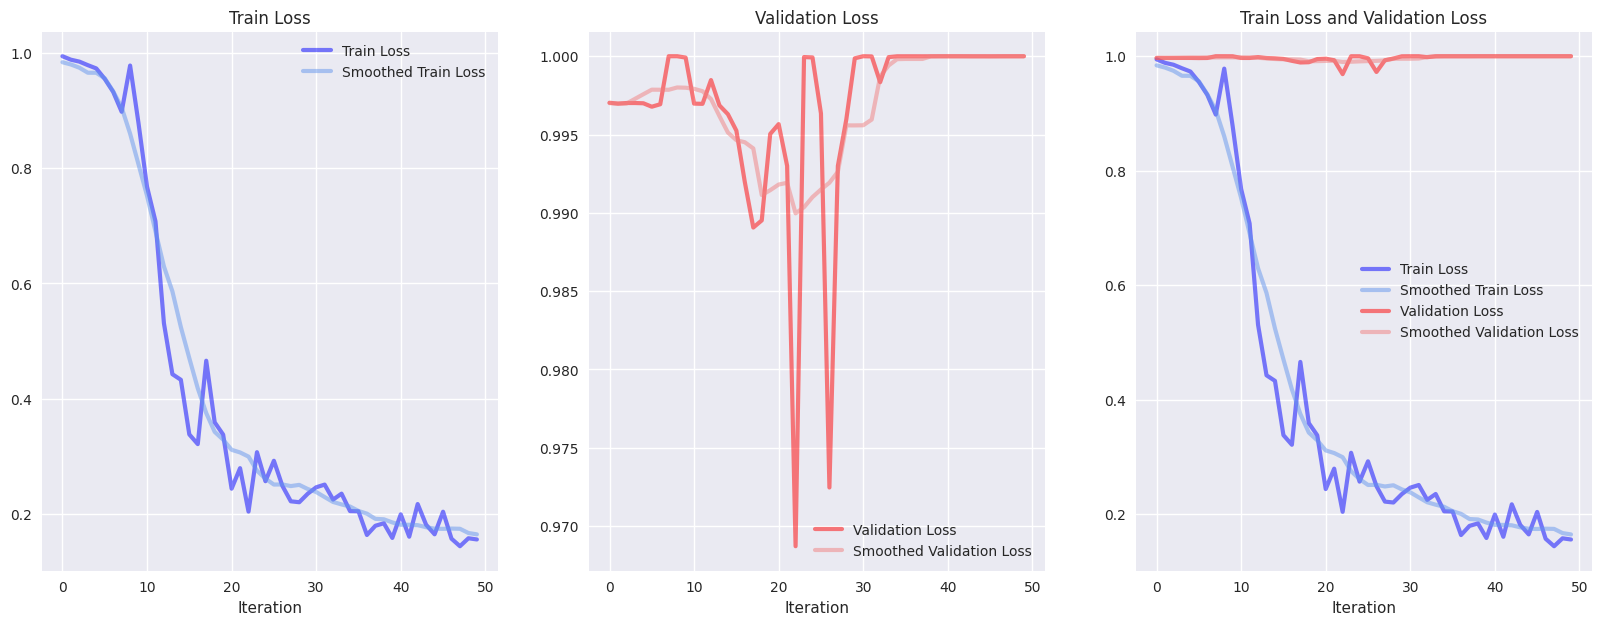

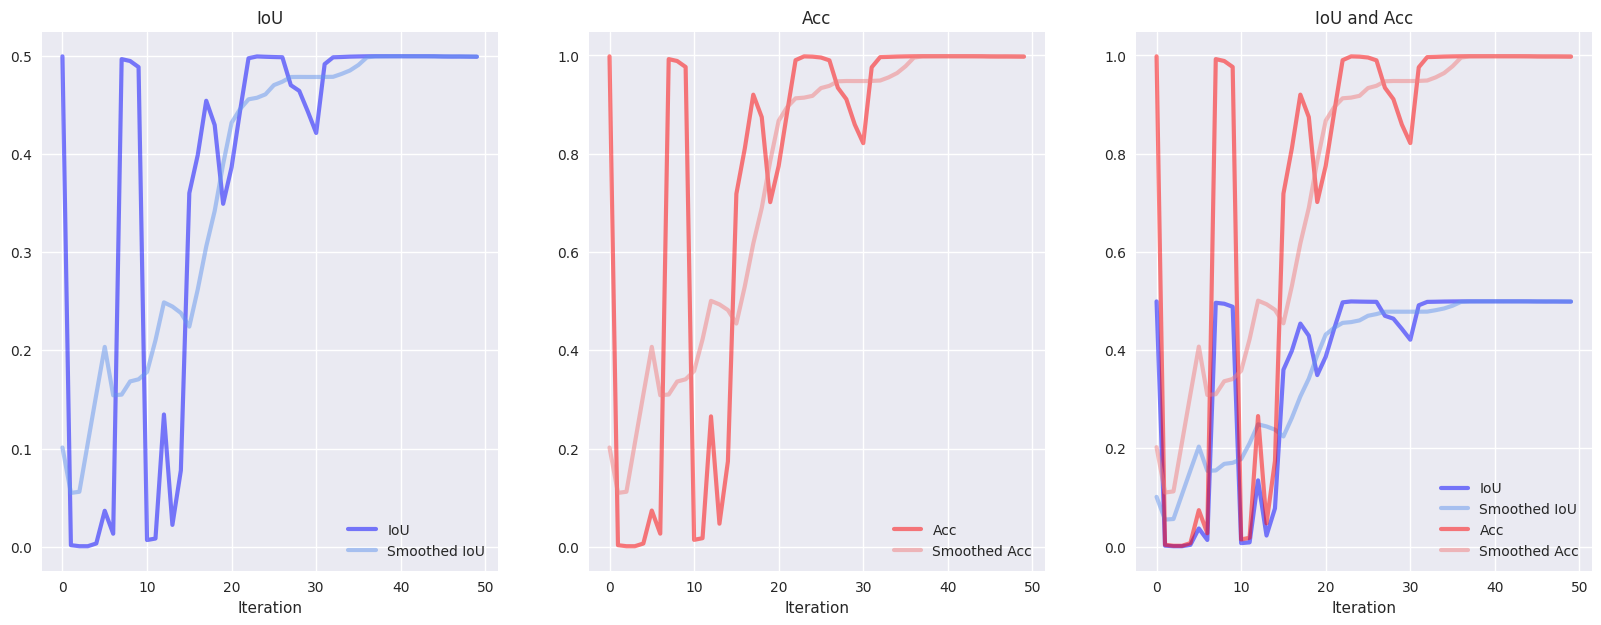

In [11]:
_, loss_ax = plot_utils.plot_results(train_loss, val_loss, ["Train Loss", "Validation Loss"])
_, measure_ax = plot_utils.plot_results(valid_mIoU, valid_mAcc, ["IoU", "Acc"])
plt.show()

### 5. Save and/or Plot Segmentation masks

#### 5.1 Train img Plot

NotImplementedError: Could not run 'torch_ipex::convolution_forward' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torch_ipex::convolution_forward' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMeta, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [kernel]
Meta: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:144 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:491 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:280 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradOther: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradCPU: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradCUDA: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradHIP: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradXLA: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradMPS: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradIPU: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradXPU: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradHPU: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradVE: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradLazy: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradMeta: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradMTIA: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradPrivateUse1: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradPrivateUse2: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradPrivateUse3: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
AutogradNestedTensor: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: registered at /opt/workspace/ipex-cpu-dev/csrc/cpu/aten/Conv.cpp:596 [kernel]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:354 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:815 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1073 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:152 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:487 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:148 [backend fallback]


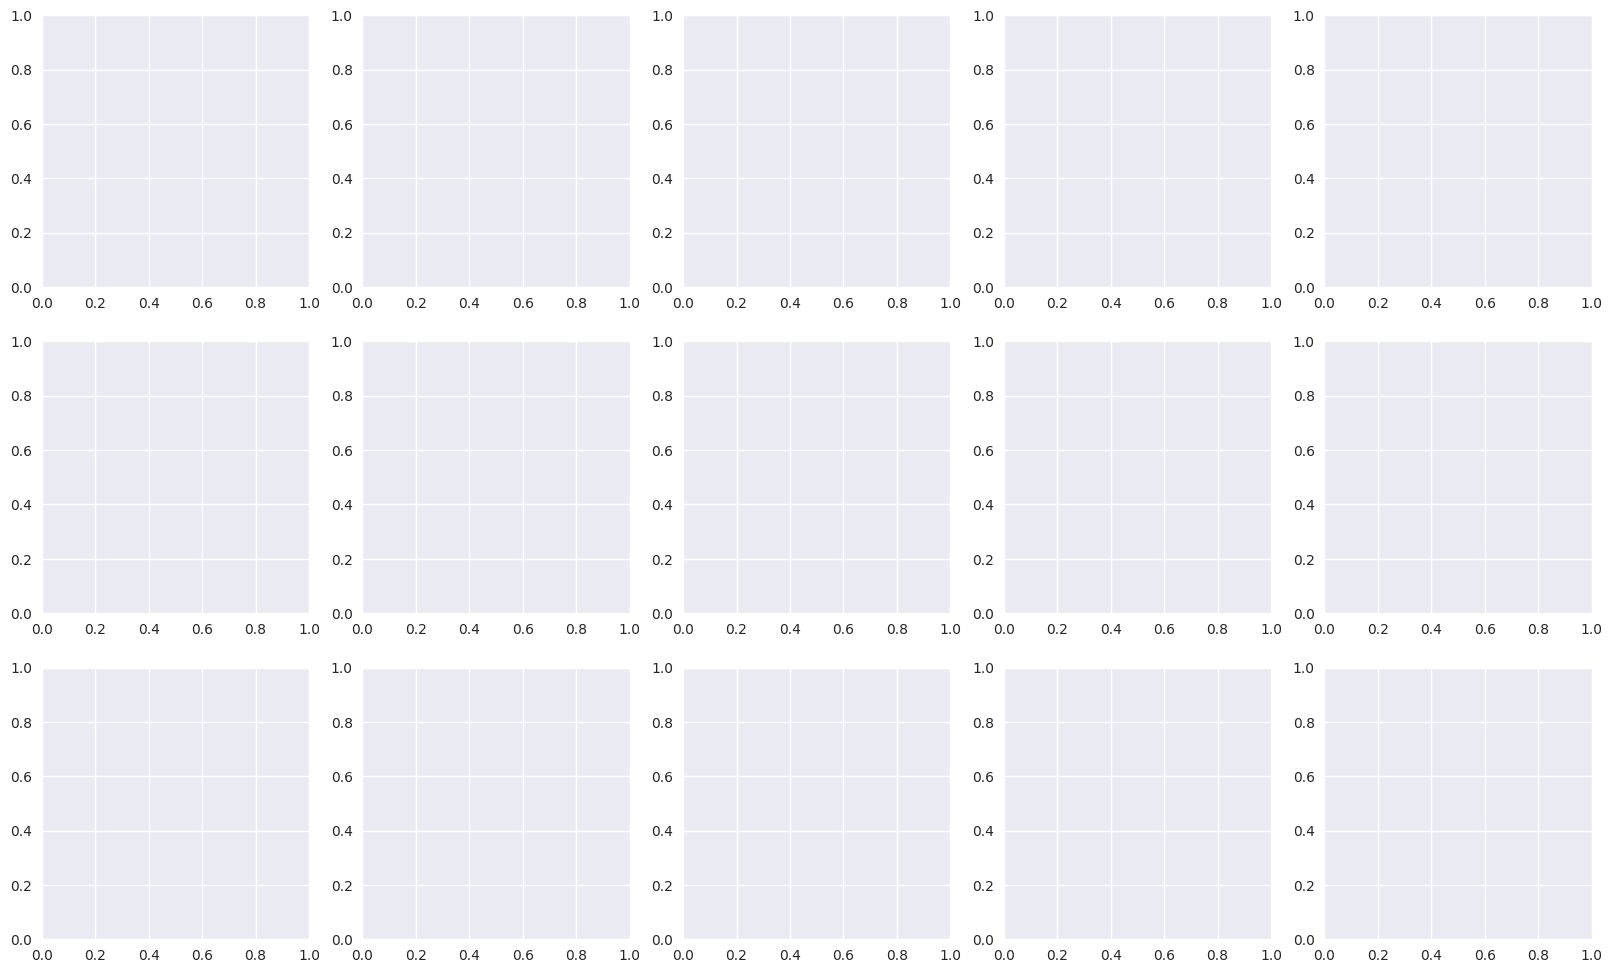

In [12]:
# plots
_, ax = plt.subplots(len(train_dataset), 5, figsize=(20,12))

for i, (img, gt_segmentation) in enumerate(train_dataset):

    optimizer.zero_grad()
    output = model(img.unsqueeze(0))

    img = img.unsqueeze(0).to("cpu")

    preds = segmentation_trainer.model(img)
    # prediction to one hot encoding
    one_hot = torch.sigmoid(preds)
    one_hot[one_hot >= 0.5] = 1
    one_hot[one_hot < 0.5] = 0

    one_hot = one_hot.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)
    gt_segmentation = gt_segmentation.numpy().transpose(1, 2, 0)
    
    vb_img = plot_utils.segment_mask_as_overlay(img, one_hot, color="red")
    vb_gt = plot_utils.segment_mask_as_overlay(img, gt_segmentation, color="blue")

    ax[i][0].grid(False)
    ax[i][0].set_title("Original Image")
    ax[i][1].grid(False)
    ax[i][1].set_title("GT Segmentation Mask")
    ax[i][2].grid(False)
    ax[i][2].set_title("GT Segmentation Overlay")
    ax[i][3].grid(False)
    ax[i][3].set_title("Predicted Segmentation Mask")
    ax[i][4].grid(False)
    ax[i][4].set_title("Predicted Segmentation Overlay")
    ax[i][0].imshow(img)
    ax[i][1].imshow(gt_segmentation)
    ax[i][2].imshow(vb_gt)
    ax[i][3].imshow(one_hot)
    ax[i][4].imshow(vb_img)


#### 5.2 Test img Plot. Optional: Save

A total of 2 images found in given path.


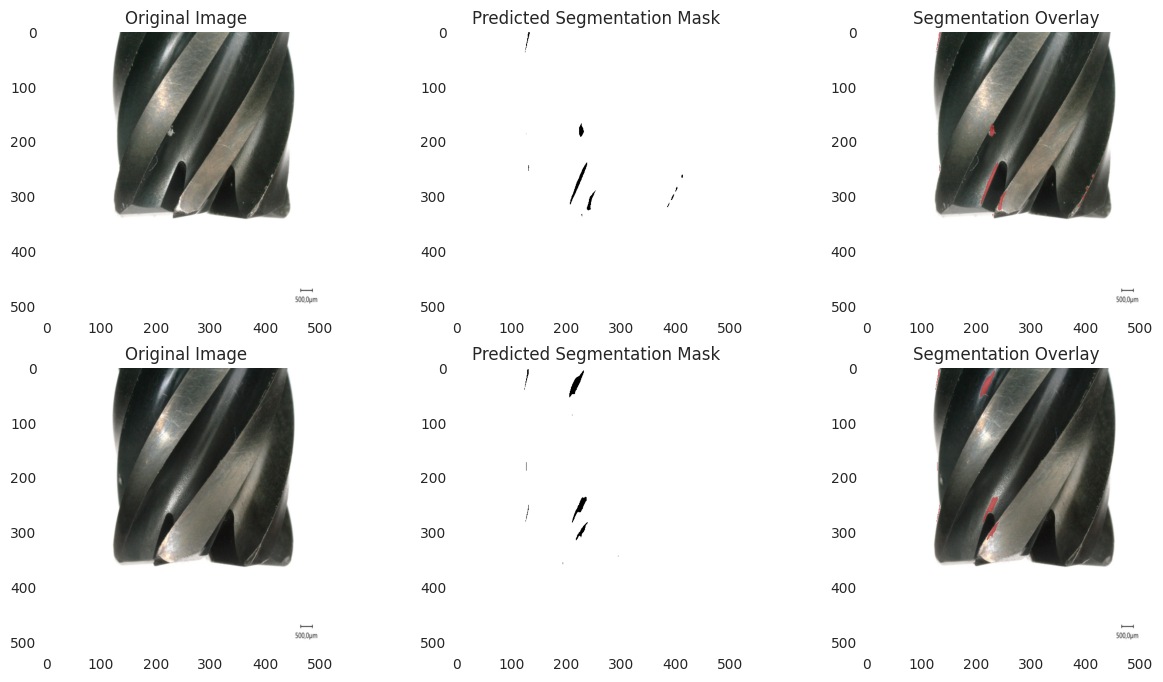

In [ ]:
test_path = "./data/test/"
test_img_paths = data_utils.collectImagePaths(test_path)

save = True
save_folder = "./data/segmented_imgs/"
os.makedirs(os.path.dirname(save_folder), exist_ok=True)

# plots
_, ax = plt.subplots(len(test_img_paths), 3, figsize=(15,8))

for i, path in enumerate(test_img_paths):
    # load image
    img = Image.open(path)
    # convert PIL to Tensor
    img = F.pil_to_tensor(img)

    # process image:
    img = F.resize(img, img_resolution, antialias=True)
    img = img / img.max()
    img = img.float().to(device)

    if len(img.shape) == 3:
        img = img.unsqueeze(0)

    preds = segmentation_trainer.model(img)
    # prediction to one hot encoding
    one_hot = torch.sigmoid(preds)
    one_hot[one_hot >= 0.5] = 1
    one_hot[one_hot < 0.5] = 0

    one_hot = one_hot.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)
    
    vb_img = plot_utils.segment_mask_as_overlay(img, one_hot, color="red")

    ax[i][0].grid(False)
    ax[i][0].set_title("Original Image")
    ax[i][1].grid(False)
    ax[i][1].set_title("Predicted Segmentation Mask")
    ax[i][2].grid(False)
    ax[i][2].set_title("Segmentation Overlay")
    ax[i][0].imshow(img)
    ax[i][1].imshow(one_hot)
    ax[i][2].imshow(vb_img)

    if save == True:
        file_name = os.path.basename(path)
        name_without_extension = os.path.splitext(file_name)[0]
        # for cv2 it wants values between 0 and 255 and BGR Channels instead of RGB
        cv2.imwrite(save_folder + name_without_extension + "_segmented.jpg", vb_img[:, :, ::-1] * 255)
